---
title: "Recipe 2: Plotting RDF and BAD with rendered scene"
subtitle: "How to Script with OVITO"
code-links:
    - text: Notebook
      icon: file-code
      href: https://colab.research.google.com/drive/1aAWJTpaEe8DwDjzC9wkA1X37z7BDi9FC?usp=sharing
---

<a target="_blank" href="https://colab.research.google.com/github/stefanbringuier/HowToSOVITO/blob/main/notebooks/HowToSOVITO_Recipe2.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>


Frequently you'll want to know what the distribution is of structural quantities. For example you may want to know where the average first nearest neighbor is or the bond-angle formed by a pair os nearest neighbors.  This reciepe will allow you to 1.) perform the analysis, 2.) add the plots to the rendered scene.

In [1]:
%%capture
! pip install -U ovito

## Import OVITO modules and Matplotlib

In [2]:
from ovito.io import import_file
from ovito.modifiers import CreateBondsModifier, BondAnalysisModifier, CoordinationAnalysisModifier
from ovito.vis import Viewport, PythonViewportOverlay
from ovito.vis import ViewportOverlayInterface
from ovito.vis import TachyonRenderer, OSPRayRenderer, OpenGLRenderer
from PySide6.QtGui import QImage, QPainter
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

## Step 1: Download LAMMPS dump and create OVITO pipeline

As usually load your file into a OVITO pipeline and the nadd it to scene.

In [3]:
%%capture
! wget  'https://drive.google.com/uc?id=1GZS1AOqJHYe4TVgqfkWR1YbRdYrPBPqB&export=download' -O dump.nacl-melt
pipeline = import_file('dump.nacl-melt')
pipeline.add_to_scene()

## Step 2: Functions for BAD and RDF

Plotting using [matplotlib](https://matplotlib.org/) is handled as normal python code. The main thing is using the OVITO calculated data (see below). Here we define the matplotlib plotting functions for the [radial distribution function](https://wikipedia.org/wiki/Radial_distribution_function) (RDF) and the bond-angle distribution (BAD). These will get used by the `Overlay` class.

::: {.callout-tip}
Note, that if you know something about the range of values for the `y` and `x` axis, you would modify that here, so that during animations the "flickering" of the plots is limited. I haven't done so here.
:::

In [4]:
def plot_bond_angle_distribution(data):
    plt.figure(figsize=(5/2,3.5/2))
    plt.bar(data[:,0], data[:,1], width=data[1,0]-data[0,0], align='center')
    plt.xlabel('Bond angle (degrees)', fontsize=8)
    plt.ylabel('Count', fontsize=8)
    ax = plt.gca()
    ax.tick_params(axis='both', which='major', labelsize=6, direction='in')
    ax.set_ylim(0.0,300)
    ax.xaxis.set_major_locator(ticker.AutoLocator())
    ax.yaxis.set_major_locator(ticker.AutoLocator())
    plt.tight_layout()
    plt.savefig('bond_angle_plot.png', dpi=300, transparent=True)
    plt.close()

def plot_radial_distribution_function(data):
    plt.figure(figsize=(5/2, 3.5/2))
    plt.plot(data[:,0], data[:,1])
    plt.xlabel('Distance', fontsize=8)
    plt.ylabel('g(r)', fontsize=8)
    ax = plt.gca()
    ax.tick_params(axis='both', which='major', labelsize=6, direction='in')
    ax.set_xlim(0.0,None)
    ax.set_ylim(0.0,5.0)
    plt.tight_layout()
    plt.savefig('rdf_plot.png', dpi=300, transparent=True)
    plt.close()

## Step 3: Class for Viewport Overlay of RDF and BAD plots

Now we define a `Overlay` class that has a method called `render`. This gets called when a `Viewport` object is rendered.

Notice that we have our `pipeline.compute` here, so all the modifiers that are set in a pipelien get called. We also cal our plotting functions and then open a canvas to add the plots to the scene.

In [5]:
class Overlay(ViewportOverlayInterface):
    def render(self, canvas, **kwargs):
      frame = kwargs['frame']
      data = pipeline.compute(frame=frame)
      plot_radial_distribution_function(data.tables['coordination-rdf'].xy())
      plot_bond_angle_distribution(data.tables['bond-angle-distr'].xy())
      with canvas.qt_painter() as painter:
        bond_angle_image = QImage('bond_angle_plot.png')
        rdf_image = QImage('rdf_plot.png')
        # Define the position and size of the images on the canvas
        bond_angle_pos = (1.0, 1.0)  # right-top corner
        rdf_pos = (1.0, 0.0)         # right-bottom corner
        size = (0.45, 0.45)          # fractional coordinates
        canvas.draw_image(bond_angle_image, pos=bond_angle_pos, size=size, anchor="north east")
        canvas.draw_image(rdf_image, pos=rdf_pos, size=size, anchor="south east")

## Step 4: OVITO Modifiers

OVITO modifiers are analysis or property calculation/setting routines. For anything you want to do, in terms of analyzing your data from a atomistic simulation, you will use a modifier which is appended to the pipeline via `pipeline.modifiers.append(...)`. Here the modifiers we use are the `BondAnalysisModifier` and `CoordinationAnalysisModifier` to grab the data for plotting the BAD and RDF.

In [6]:
# Create bonds if not already in the dump
pipeline.modifiers.append(CreateBondsModifier(cutoff=3.5))

# Calculate the bond-angle distribution
bond_angle_modifier = BondAnalysisModifier()
pipeline.modifiers.append(bond_angle_modifier)

# Calculate the radial distribution function
rdf_modifier = CoordinationAnalysisModifier(cutoff=6.5, number_of_bins=100)
pipeline.modifiers.append(rdf_modifier)

## Step 5: Viewport and Render
As usually we need to create our `Viewport` object and then configure it based on how we want to view the scene.

Then because we are overlaying additional images that have been created by [matplotlib](https://matplotlib.org) we need to provide our overlay object to the viewport. Then we add the pipeline to the scene.

In [7]:
viewport = Viewport(type=Viewport.Type.Ortho, camera_dir=(2, 1, -1))
viewport.zoom_all()
viewport.camera_pos = [15, -1, 15]

overlay = PythonViewportOverlay(delegate=Overlay())
viewport.overlays.append(overlay)

pipeline.add_to_scene();

:::{.callout-note}
We just use the code below to display an image in a notebook.
:::

In [8]:
from IPython.display import Image

### Render Single Frame

In [15]:
# Render image
frame=9
fstatic = f'nacl_melt_rendered_frame_{frame}.png'
viewport.render_image(size=(800, 600),
                      frame=frame,
                      filename=fstatic,
                      renderer=OSPRayRenderer());

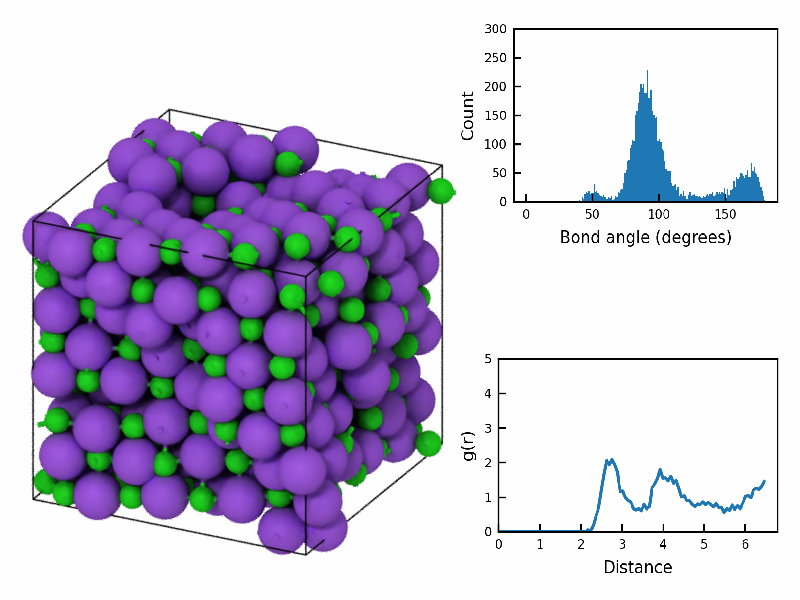

In [16]:
Image(open(fstatic, 'rb').read())

## Animation

In [13]:
fanim = 'nacl_melt_animation.gif'
viewport.render_anim(size=(800, 600),
                     every_nth=5,
                     filename=fanim,
                     renderer=OSPRayRenderer(),
                     fps=10)

![](../resources/recipe2_animation.gif)